In [1]:
from sympy import *
from sympy.physics.mechanics import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

init_vprinting()

In [190]:
m1, m2, m3, l, g, t, tau2, tau3 = symbols('m1 m2 m3 l g t tau2 tau3')
theta1, theta2, theta3 = dynamicsymbols('theta1 theta2 theta3')

p1 = Matrix([[l*sin(theta1)], [-l*cos(theta1)]])
p2 = p1 + Matrix([[l*sin(theta1+theta2)], [-l*cos(theta1+theta2)]])
p3 = p2 + Matrix([[l*sin(theta1+theta2+theta3)], [-l*cos(theta1+theta2+theta3)]])

dp1 = Matrix([[diff(p1, theta1), diff(p1, theta2), diff(p1, theta3)]])
dp2 = Matrix([[diff(p2, theta1), diff(p2, theta2), diff(p2, theta3)]])
dp3 = Matrix([[diff(p3, theta1), diff(p3, theta2), diff(p3, theta3)]])

theta1_dot = diff(theta1, t)
theta2_dot = diff(theta2, t)
theta3_dot = diff(theta3, t)
theta1_ddot = diff(theta1_dot, t)
theta2_ddot = diff(theta2_dot, t)
theta3_ddot = diff(theta3_dot, t)

theta = Matrix([[theta1], [theta2], [theta3]])
theta_dot = Matrix([[theta1_dot], [theta2_dot], [theta3_dot]])
theta_ddot = Matrix([[theta1_ddot], [theta2_ddot], [theta3_ddot]])

In [3]:
U = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1]
K = (1/2*(m1*theta_dot.T*dp1.T*dp1*theta_dot + m2*theta_dot.T*dp2.T*dp2*theta_dot + m3*theta_dot.T*dp3.T*dp3*theta_dot))[0]
L = K - U

eqn1 = diff(diff(L, theta1_dot), t) - diff(L, theta1)
eqn2 = diff(diff(L, theta2_dot), t) - diff(L, theta2)
eqn3 = diff(diff(L, theta3_dot), t) - diff(L, theta3)

eqn = simplify(Matrix([[eqn1], [eqn2], [eqn3]]))

In [4]:
M = simplify(m1*dp1.T*dp1 + m2*dp2.T*dp2 + m3*dp3.T*dp3)
N = simplify(eqn - M*theta_ddot)
M_bar = simplify(M[1:3, 1:3] - M[1:3, 0]*M[0, 1:3]/M[0, 0])
N_bar = simplify(N[1:3, 0] - M[1:3, 0]*N[0, 0]/M[0, 0])
M_bar_inv = M_bar.inv()

In [191]:
alpha = Matrix([[1], [-1]])
P = eye(2) - alpha*alpha.T*M_bar_inv/(alpha.T*M_bar_inv*alpha)[0]

theta_dot_sym = Matrix([
        [((-M[0, 1:3]*theta_ddot[1:3, 0])[0] - N[0])/M[0, 0]],
        M_bar_inv*(Matrix([[tau2], [tau3]]) - N_bar)#*P # for MLS
    ])
theta1_ddot_expr = lambdify((m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, theta2_ddot, theta3_ddot, tau2, tau3), theta_dot_sym[0], modules='numpy')
theta2_ddot_expr = lambdify((m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau2, tau3), theta_dot_sym[1], modules='numpy')
theta3_ddot_expr = lambdify((m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau2, tau3), theta_dot_sym[2], modules='numpy')

In [182]:
# Constrained control
K1 = 2
K2 = 2
u = -K1*(theta2-2*pi/3) - K2*theta2_dot
tt = ((M_bar[0, 0]-M_bar[0, 1]*M_bar[1, 0]/M_bar[1, 1])*u + (Matrix([1, -M_bar[1, 0]/M_bar[1, 1]]).T*(P*N_bar))[0]) / (P[0, 0]-M_bar[0, 1]/M_bar[1, 1]*P[1, 0])
tau2_expr = lambdify((m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tt, modules='numpy')

In [7]:
M_adj = (M[1:3, 1:3]*M[0, 0] - M[1:3, 0]*M[0, 1:3]).adjugate()
Pp = simplify(expand(alpha*alpha.T*M_adj)) / simplify((alpha.T*M_adj*alpha)[0])
Pp

⎡                                                         ⎛                   
⎢                                                      m₃⋅⎝m₁⋅cos(θ₃) + 2⋅m₁ -
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                      2    2         2                       
⎢m₁⋅m₂ + 4⋅m₁⋅m₃⋅cos(θ₃) + 5⋅m₁⋅m₃ - m₂ ⋅cos (θ₂) + m₂  - 4⋅m₂⋅m₃⋅cos(θ₂ + θ₃)
⎢                                                                             
⎢                                                         ⎛                   
⎢                                                      m₃⋅⎝-m₁⋅cos(θ₃) - 2⋅m₁ 
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                      2    2         2                       
⎣m₁⋅m₂ + 4⋅m₁⋅m₃⋅cos(θ₃) + 5⋅m₁⋅m₃ - m₂ ⋅cos (θ₂) + m₂  - 4⋅m₂⋅m₃⋅cos(θ₂ + θ₃)

                                                                              
 m₂⋅cos(θ₂ + θ₃)⋅cos(θ₂) - m₂⋅cos(θ₂ + θ₃) + m₂⋅cos

In [192]:
# MLS control
K1 = diag(2, 4)
K2 = diag(2, 4)
e = Matrix([[theta2-2*pi/3], [theta3-2*pi/3]])
e_dot = Matrix([[theta2_dot], [theta3_dot]])
tau_sym = M_bar*(-K1*e-K2*e_dot) + N_bar#Matrix([[N_bar[0]], [0]])#[N_bar[1].subs({theta1: 0, theta1_dot: 0})]])
tau2_expr = lambdify((m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tau_sym[0], modules='numpy')
tau3_expr = lambdify((m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tau_sym[1], modules='numpy')

In [193]:
m1 = 1
m2 = 1
m3 = 1
l = 1
g = 9.81

dt = 0.01
tf = 15
t = np.arange(0, tf, dt)

theta1_0 = 0
theta2_0 = -np.pi/2
theta3_0 = np.pi/2
theta1_dot_0 = 0
theta2_dot_0 = 0
theta3_dot_0 = 0

def ODE(t, y):
    theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot = y
    tau2 = tau2_expr(m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot)
    tau3 = tau3_expr(m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot)
    theta2_ddot = theta2_ddot_expr(m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau2, tau3)
    theta3_ddot = theta3_ddot_expr(m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau2, tau3)
    theta1_ddot = theta1_ddot_expr(m1, m2, m3, l, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, theta2_ddot, theta3_ddot, tau2, tau3)
    return (theta1_dot, theta2_dot, theta3_dot, theta1_ddot, theta2_ddot, theta3_ddot)

sol = solve_ivp(ODE, (0, tf), (theta1_0, theta2_0, theta3_0, theta1_dot_0, theta2_dot_0, theta3_dot_0), t_eval=t)
theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot = sol.y

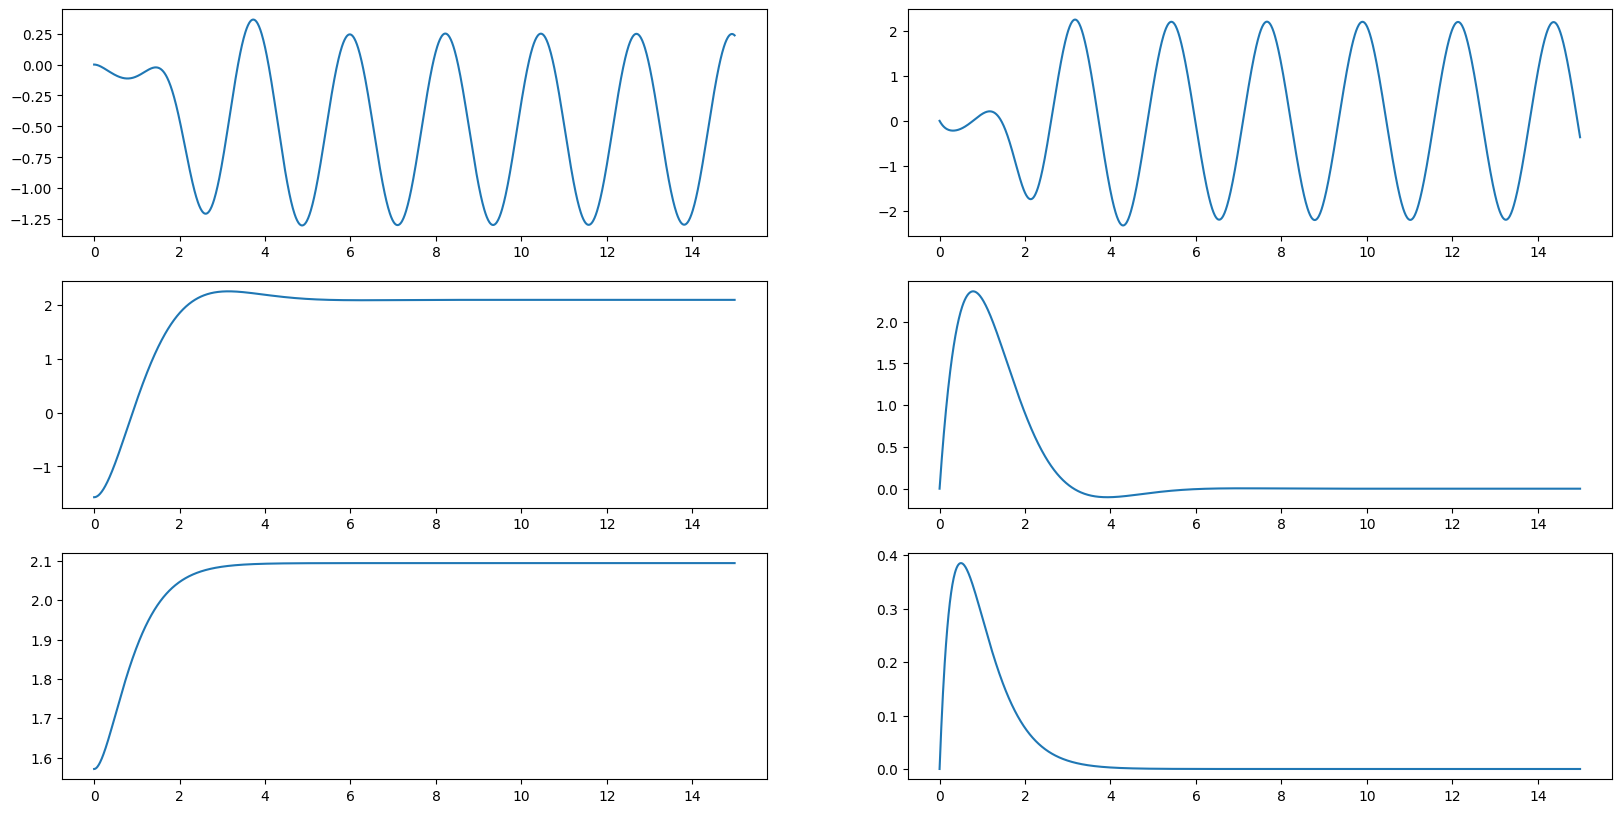

In [194]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(t, theta1, label=r'$\theta_1$')
plt.subplot(3, 2, 3)
plt.plot(t, theta2, label=r'$\theta_2$')
plt.subplot(3, 2, 5)
plt.plot(t, theta3, label=r'$\theta_3$')

plt.subplot(3, 2, 2)
plt.plot(t, theta1_dot, label=r'$\dot{\theta}_1$')
plt.subplot(3, 2, 4)
plt.plot(t, theta2_dot, label=r'$\dot{\theta}_2$')
plt.subplot(3, 2, 6)
plt.plot(t, theta3_dot, label=r'$\dot{\theta}_3$')

In [179]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
ax.grid()

# Plot initial position
line1 = ax.plot([0, l*np.sin(theta1[0])], [0, -l*np.cos(theta1[0])], 'o-', lw=2)[0]
line2 = ax.plot([l*np.sin(theta1[0]), l*np.sin(theta1[0])+l*sin(theta1[0]+theta2[0])], [-l*np.cos(theta1[0]), -l*np.cos(theta1[0])-l*np.cos(theta1[0]+theta2[0])], 'o-', lw=2)[0]
line3 = ax.plot([l*np.sin(theta1[0])+l*sin(theta1[0]+theta2[0]), l*np.sin(theta1[0])+l*sin(theta1[0]+theta2[0])+l*sin(theta1[0]+theta2[0]+theta3[0])], [-l*np.cos(theta1[0])-l*np.cos(theta1[0]+theta2[0]), -l*np.cos(theta1[0])-l*np.cos(theta1[0]+theta2[0])-l*np.cos(theta1[0]+theta2[0]+theta3[0])], 'o-', lw=2)[0]

# Text box for time and torque
#text = ax.text(0.05, 0.9, f'time: {t[0]:.1f} s\ntau: {tau[0]:.1f} Nm', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=18)

fps = 30
def animate(i):
    i = int(i/(fps*dt))
    line1.set_data([0, l*np.sin(theta1[i])], [0, -l*np.cos(theta1[i])])
    line2.set_data([l*np.sin(theta1[i]), l*np.sin(theta1[i])+l*sin(theta1[i]+theta2[i])], [-l*np.cos(theta1[i]), -l*np.cos(theta1[i])-l*np.cos(theta1[i]+theta2[i])])
    line3.set_data([l*np.sin(theta1[i])+l*sin(theta1[i]+theta2[i]), l*np.sin(theta1[i])+l*sin(theta1[i]+theta2[i])+l*sin(theta1[i]+theta2[i]+theta3[i])], [-l*np.cos(theta1[i])-l*np.cos(theta1[i]+theta2[i]), -l*np.cos(theta1[i])-l*np.cos(theta1[i]+theta2[i])-l*np.cos(theta1[i]+theta2[i]+theta3[i])])
    #text.set_text(f'time: {t[i]:.1f} s\ntau: {tau[i]:.1f} Nm')

tf_sim = tf
ani = animation.FuncAnimation(fig, animate, frames=fps*tf_sim)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'pendulizable.mp4', writer=ffmpeg_writer)
plt.close(fig)